In [1]:
import datajoint as dj
dj.config['database.host'] = 'ucsd-demo-db.datajoint.io'
dj.config['database.user'] = 'conrad'
dj.config['database.password'] = 'pw4dklab'

In [2]:
schema = dj.schema('conrad_test')

Connecting conrad@ucsd-demo-db.datajoint.io:3306


In [4]:
@schema
class Mouse(dj.Manual):
    definition = """
    #Mouse in the lab 
    mouse_id : char(8) #unique mouse id
    ---
    dob : date
    iacuc_barcode: bigint unsigned
    sex = 'M': enum('M','F')
    genotype = 'C57/Bl6': varchar(1000)
    """

In [ ]:
Mouse.insert1(dict(mouse='CF_A1_05',dob='2018-2-08',iacuc_barcode=2,sex='M',genotype='C57/Bl6'))

In [6]:
@schema
class Session(dj.Manual):
    definition="""
    ->Mouse
    session : tinyint unsigned #Session number for the mouse
    ---
    path_to_tiff : varchar(1000) #Two photon tiff file
    path_to_adi : varchar(1000) #Labchart file with behavioural data
    adi_trial_num : tinyint #The session number in the adicht file associated with session
    type : enum('naive','fbd1','fbd2','post') #Type of experimental trial
    """

In [9]:
Session()

mouse_id unique mouse id - CF_Sensor_number,session The session number,path_to_tiff Two photon tiff file,path_to_adi Labchart file with behavioural data,adi_trial_num The session number in the adicht file associated with this session,session_date The date of the session,type The type of experimental trial
CF_D2_01,1,G:\D2_1\baseline_00003.tif,G:\D2_1\d2_fb_1.adicht,2,2018-04-29,naive
CF_D2_01,2,G:\D2_1\baseline_00004.tif,G:\D2_1\d2_fb_1.adicht,3,2018-04-29,fbd1
CF_D2_01,3,G:\D2_1\feedback_00002.tif,G:\D2_1\d2_fb_1.adicht,5,2018-04-29,fbd1
CF_D2_01,4,G:\D2_1\Day 2\feedback_00001.tif,G:\D2_1\d2_fb_3.adicht,1,2018-04-30,fbd2
CF_D2_01,5,G:\D2_1\Day 2\post_00002.tif,G:\D2_1\d2_fb_3.adicht,4,2018-04-30,post


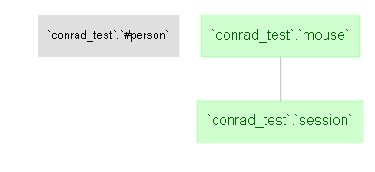

In [3]:
dj.ERD(schema).draw()

In [7]:
@schema
class TestPopulate(dj.Imported):
    definition="""
    ->Session
    -----
    expmt_type : varchar(1000) #Return the session type.
    """
    
    def make(self, key):
        img = (Session & key).fetch1('type')
        print(key)
        key['expmt_type'] = img
        print(key)
        self.insert1(key)

In [23]:
z = Session() & "mouse_id = 'CF_D2_01'" & "type = 'fbd1'"

In [28]:
data = z.fetch()

In [13]:
data = TestPopulate.fetch()

In [22]:
(TestPopulate & 'mouse_id = "CF_D2_01"').delete();

About to delete:
`conrad_test`.`_test_populate`: 5 items
Proceed? [yes, No]: yes
Committed.


In [26]:
TestPopulate.populate()

{'mouse_id': 'CF_D2_01', 'session': 1}
{'mouse_id': 'CF_D2_01', 'session': 1, 'expmt_type': 'naive'}
{'mouse_id': 'CF_D2_01', 'session': 2}
{'mouse_id': 'CF_D2_01', 'session': 2, 'expmt_type': 'fbd1'}
{'mouse_id': 'CF_D2_01', 'session': 4}
{'mouse_id': 'CF_D2_01', 'session': 4, 'expmt_type': 'fbd2'}


In [27]:
TestPopulate.fetch()

array([('CF_D2_01', 1, 'naive'), ('CF_D2_01', 2, 'fbd1'),
       ('CF_D2_01', 3, 'fbd2'), ('CF_D2_01', 4, 'fbd2'),
       ('CF_D2_01', 5, 'fbd2')],
      dtype=[('mouse_id', 'O'), ('session', '<i8'), ('expmt_type', 'O')])

In [44]:
@schema
class Imaging(dj.Imported):
    definition = """
    ->Session
    ---
    roi_img : longblob #The ROI used for calculating the fluorescence traces
    yfp : longblob #The YFP fluorescence trace (dF/F)
    cfp : longblob #The CFP fluorescence trace (dF/F)
    fret : longblob #The FRET signal (dR/R = yfp/cfp - 1)
    thresh : longblob #The reward threshold for the FRET signal
    t : longblob #The time from the start of the imaging session
    si : longblob #The scanimage property structure
    """
    
    def make(self,key):
        self.insert1(key)

In [45]:
import numpy as np
z = dict(mouse_id = 'CF_D2_01', session = 1, roi_img = np.zeros([512,512],dtype = float), yfp = np.zeros(15000,dtype = float), cfp = np.zeros(15000,dtype = float), fret = np.zeros(15000,dtype = float), thresh = np.zeros(15000,dtype = float), t = np.zeros(15000,dtype = float), si = dict())

In [46]:
Imaging.insert1(z)

In [39]:
@schema
class Behavior(dj.Imported):
    definition="""
    ->Session
    ---
    lick_freq : longblob #The frequency of licks (Hz)
    ang_vel : longblob #The angular velocity of running (deg/s)
    t : longblob #The time from start of imaging session (s)
    """
    
    def make(self,key):
        self.insert1(key)

In [41]:
z = dict(mouse_id = 'CF_D2_01',session = 1, lick_freq = np.zeros(3529412,dtype=float), ang_vel = np.zeros(3529412,dtype=float), t = np.zeros(3529412,dtype=float))

In [42]:
Behavior.insert1(z)